In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

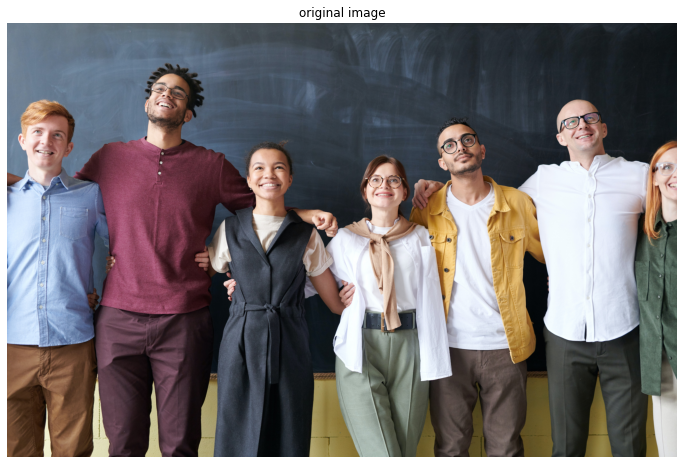

In [2]:
img = cv2.imread("image1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.title("original image")
plt.imshow(img)
plt.axis("off")
plt.show()

In [3]:
def warpAffine(img, M, output_size, flags):
    rows, cols = img.shape[:2]
    output = np.zeros(output_size + (img.shape[2],), dtype=img.dtype)

    for y in range(output_size[1]):
        for x in range(output_size[0]):
            pt = np.array([x, y, 1])
            new_pt = M @ pt
            new_x = int(new_pt[0])
            new_y = int(new_pt[1])

            if 0 <= new_x < cols and 0 <= new_y < rows:
                output[y, x] = img[new_y, new_x]
    
    output = cv2.resize(output, (output_size[0], output_size[1]), interpolation=flags)
    return output


def warpPerspective(img, M, output_size, flags):
    output = np.zeros(output_size + (img.shape[2],), dtype=img.dtype)
    
    for y in range(output_size[0]):
        for x in range(output_size[1]):
            pt = np.array([x, y, 1])
            new_pt = M @ pt
            if new_pt[2] != 0:
                new_x = int(new_pt[0] / new_pt[2])
                new_y = int(new_pt[1] / new_pt[2])
                if (new_x >= 0 and new_x < img.shape[1] and
                    new_y >= 0 and new_y < img.shape[0]):
                    output[y, x] = img[new_y, new_x]
    
    output = cv2.resize(output, (output_size[0], output_size[1]), interpolation=flags)
    return output

In [4]:
# non-linear transformation
perspective = np.float32([    [1, 0, 0],
    [0, 1, 0],
    [0.001, 0.002, 1]
])

barrel = np.zeros((3, 3))
barrel[0, 0] = barrel[1, 1] = 0.8
barrel[2, 0] = barrel[2, 1] = 0.001
barrel[2, 2] = 1

pinch = np.zeros((3, 3))
pinch[0, 0] = pinch[1, 1] = 1
pinch[2, 0] = 0.005
pinch[2, 1] = -0.005
pinch[2, 2] = 1

swirl = np.zeros((3, 3))
swirl[0, 0] = swirl[1, 1] = 1
swirl[0, 1] = 0.5
swirl[1, 0] = -0.5
swirl[2, 2] = 1

nonlinear_transformations = [
    perspective,
    barrel,
    pinch,
    swirl
]

In [5]:
linear_transformations = [
    np.float32([[1, 0, 50], [0, 1, 50]]), # Shifts the image horizontally and vertically by 50 pixels in both directions.
    cv2.getRotationMatrix2D((0, 0), 45, 1), # Rotates the image by 45 degrees
    np.float32([[1, 0.5, 0], [0.5, 1, 0]]), # Enlarges the image by a factor of 1.5 in both x and y directions
    np.float32([[1, 0.5, 50], [-0.3, 1, 0]]) # Shears the image in the x direction by a factor of 0.5 and shifts it 50 pixels to the right,
]

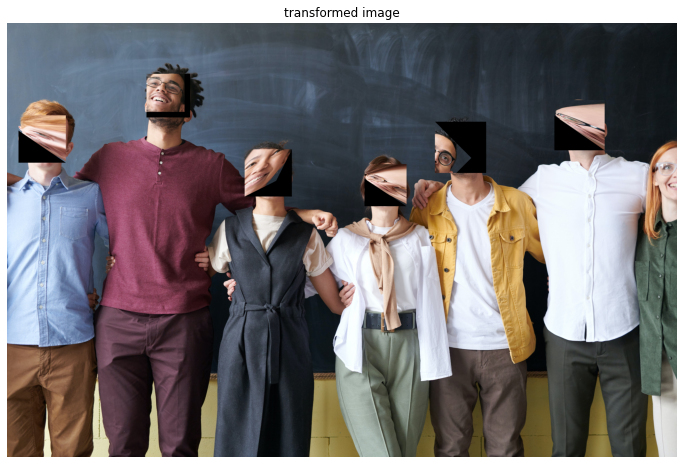

In [7]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.15, minNeighbors=10)

transformations = linear_transformations + nonlinear_transformations

for (x, y, w, h) in faces:
    face = img[y:y+h, x:x+w]

    transformation = random.choice(transformations)

    if transformation.shape[0] == 2:
        transformed_face = warpAffine(face, transformation, (w, h), flags=cv2.INTER_AREA)
    else:
        transformed_face = warpPerspective(face, transformation, (w, h), flags=cv2.INTER_AREA)

    img[y:y+h, x:x+w] = transformed_face

plt.figure(figsize=(12, 8))
plt.title("transformed image")
plt.imshow(img)
plt.axis("off")
plt.show()